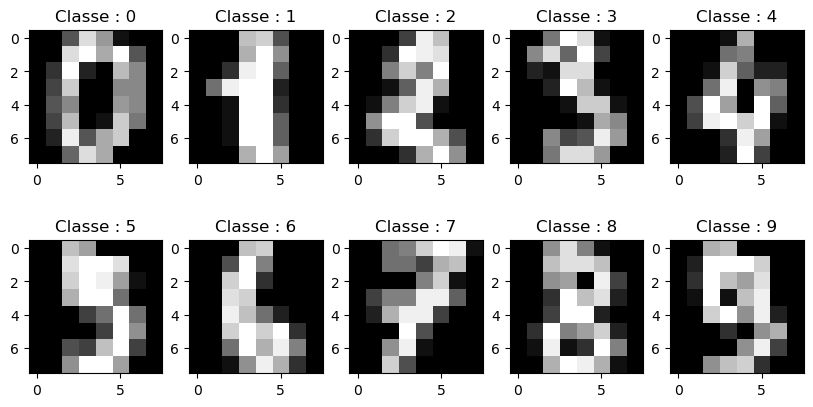

In [1]:
from sklearn.datasets import load_digits
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt 
import seaborn as sns
import numpy as np

# Chargez le jeu de données MNIST
digits = load_digits()
X, y = digits["data"], digits["target"]

#X, y = ["data"], ["target"]

# Affichez quelques images
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.ravel()):  #enumerate() allows to complete the subplot, here with 2*5 elements
    ax.imshow(X[i].reshape(8, 8), cmap="gray")
    ax.set_title(f"Classe : {y[i]}")
plt.show()

In [2]:
y


array([0, 1, 2, ..., 8, 9, 8])

In [3]:
X.shape

(1797, 64)

Means that the data set is about 1797 object containing 64 values each (8*8) image here

In [4]:
actual_cl_len = len(np.unique(y)) #length of y, since we're on ground truth so we need to know the number of cluster we want

actual_cl_len

10

Import metrics

In [5]:
def clust_metrics(estimator, data, y = None): #function to evaluate clustering model

    from sklearn.metrics import rand_score, adjusted_rand_score
    from sklearn.metrics import ( mutual_info_score, normalized_mutual_info_score, adjusted_mutual_info_score)
    from sklearn.metrics import ( homogeneity_score, completeness_score, v_measure_score)
    from sklearn.metrics import fowlkes_mallows_score
    from sklearn.metrics import silhouette_score
    from sklearn.metrics import calinski_harabasz_score
    from sklearn.metrics import davies_bouldin_score
    import pandas as pd

    estimator.fit_predict(data)

    metrics_GT = [rand_score, adjusted_rand_score, mutual_info_score, normalized_mutual_info_score, 
               adjusted_mutual_info_score, homogeneity_score, completeness_score, v_measure_score, 
               fowlkes_mallows_score]
    
    metrics_unk = [ silhouette_score, calinski_harabasz_score, davies_bouldin_score]

    score = []
    
    if y is not None :
        for n in metrics_GT :
            met = n(y, estimator.labels_)
            score.append(round(met, 2))

        for n in metrics_unk :
            met = n(data, estimator.labels_)
            score.append(round(met, 2))
    
        return pd.DataFrame({"Clustering Metrics": score}, index=['Rand_Index', 'Adjusted_Rand_Index', 'Mutual_Information', 'Normalized_Mutual_Information', 
               'Adjusted_Mutual_Information', 'Homogeneity_score', 'Completeness_score', 'V_measure_score', 
               'Fowlkes_Mallows_score','Silhouette_score', 'Calinski_Harabasz_score', 'Davies_Bouldin_score'])
    
    else :
        for n in metrics_unk :
            met = n(data, estimator.labels_)
            score.append(round(met, 2))

        return pd.DataFrame({"Clustering Metrics": score}, index=['Silhouette_score', 'Calinski_Harabasz_score', 'Davies_Bouldin_score'])

In [6]:
model = KMeans(n_clusters = len(np.unique(y)), n_init= 10)

model.fit(X)



clust_metrics(model, X, y)

,Clustering Metrics
Rand_Index,0.94
Adjusted_Rand_Index,0.67
Mutual_Information,1.70
Normalized_Mutual_Information,0.74
Adjusted_Mutual_Information,0.74
Homogeneity_score,0.74
Completeness_score,0.75
V_measure_score,0.74
Fowlkes_Mallows_score,0.70
Silhouette_score,0.18


In [7]:
# PCA Transformation - Reduce dimension to a 2D features shape.
from sklearn.decomposition import PCA

pca = PCA(2)
X2 = pca.fit_transform(X)

model2 = KMeans(n_clusters=10, n_init=10)
y_pred2 = model.fit_predict(X2)


clust_metrics(model2, X2, y)


,Clustering Metrics
Rand_Index,0.89
Adjusted_Rand_Index,0.41
Mutual_Information,1.23
Normalized_Mutual_Information,0.54
Adjusted_Mutual_Information,0.53
Homogeneity_score,0.54
Completeness_score,0.54
V_measure_score,0.54
Fowlkes_Mallows_score,0.47
Silhouette_score,0.40


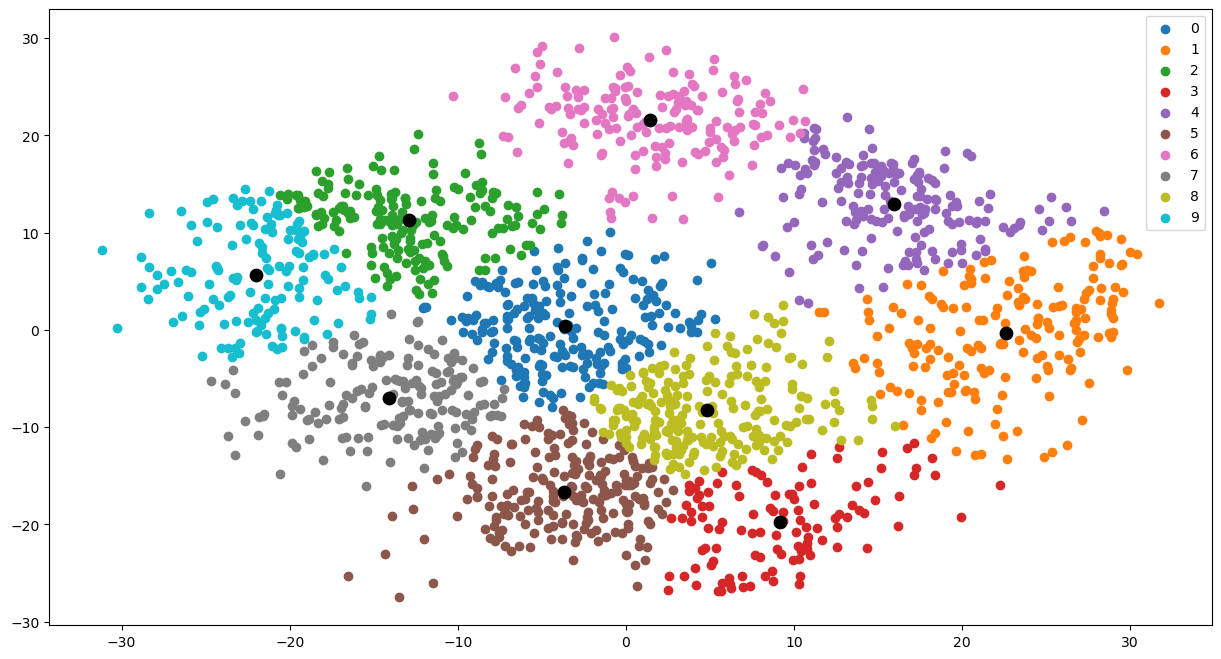

In [8]:
centroids = model.cluster_centers_
unique_labels = np.unique(y_pred2)
 
# Plot 2D result
fig = plt.figure(1, figsize=(15, 8))
for i in unique_labels:
    plt.scatter(X2[y_pred2 == i , 0] , X2[y_pred2 == i , 1] , label=i)
plt.scatter(centroids[:,0] , centroids[:,1] , s=80, color='k')
plt.legend()
plt.show()

20newsgroup Work

I) Exploring the data

In [9]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.metrics import confusion_matrix, make_scorer, precision_score, recall_score, f1_score
import seaborn as sns
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt



newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')

X_train = newsgroups_train.data #liste de toute les données train
X_test = newsgroups_test.data #liste de toute les données text
y_train = newsgroups_train.filenames #liste de tous les noms de texte
y_test = newsgroups_test.filenames #liste de tous les noms de texte
z = (list(newsgroups_train.target_names))
z #show newsgroup categories

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Explore : Show categories and their size

In [10]:
labels_train = newsgroups_train.target
unique_labels_train, category_sizes_train = np.unique(labels_train, return_counts=True)
labels_test = newsgroups_test.target
unique_labels_test, category_sizes_test = np.unique(labels_test, return_counts=True)


Cat_size = pd.DataFrame({"Topics_Label": (list(newsgroups_train.target_names)), "Train_category_size" : category_sizes_train, "Test_category_size" : category_sizes_test})

Cat_size

,Topics_Label,Train_category_size,Test_category_size
0,alt.atheism,480,319
1,comp.graphics,584,389
2,comp.os.ms-windows.misc,591,394
3,comp.sys.ibm.pc.hardware,590,392
4,comp.sys.mac.hardware,578,385
5,comp.windows.x,593,395
6,misc.forsale,585,390
7,rec.autos,594,396
8,rec.motorcycles,598,398
9,rec.sport.baseball,597,397


In [11]:
print('Train list contain ', len(y_train), 'articles') #Explore : numbers of articles
print('Test list contain ', len(y_test), 'articles') #Explore : numbers of articles


Train list contain  11314 articles
Test list contain  7532 articles


In [12]:
print(X_train[1988]) #Explore : example of an article

From: smithw@col.hp.com (Walter Smith)
Subject: Re: Playoff predictions
Organization: Colorado Springs IT Center
Lines: 41
NNTP-Posting-Host: fajita19.cs.itc.hp.com

OK, I'll join in the fun and give my playoff predictions: 

1st round: 
----------

PITT vs NYI:  PITT in 4.  
WASH vs NJD:  WASH in 6. 

BOS  vs BUF:  BOS  in 5. 
QUE  vs MON:  MON  in 7. 

CHI  vs STL:  CHI in 4. 
DET  vs TOR:  DET in 6. 

VAN  vs WIN:  WIN in 6. 
CAL  vs  LA:  CAL in 5. 

2nd round: 
----------

PITT vs WASH: PITT in 4. 
BOS  vs MON:  BOS  in 6. 

CHI  vs DET:  CHI  in 7. 
WIN  vs CAL:  CAL  in 5. 

3rd round: 
----------

PITT vs BOS:  PITT in 5. 
CHI  vs CAL:  CHI  in 5. 

Finals:
------

PITT vs CHI: PITT in 5. 


Walter




In [13]:
print(X_train[67]) #Explore : example of an article

From: lwb@cs.utexas.edu (Lance W. Bledsoe)
Subject: Re: ATF suspects drug lab in compound
Organization: CS Dept, University of Texas at Austin
Lines: 24
NNTP-Posting-Host: im4u.cs.utexas.edu

>In article <1993Mar28.180629.21574@mnemosyne.cs.du.edu> rcanders@nyx.cs.du.edu (Mr. Nice Guy) writes:
>>A Associated Press News story 3/28/93 reports:
>> 
>>"    In other developments Saturday, David Troy, intelligence chief for
>>the ATF, confirmed reports that authorities suspected the cult had a
>>methamphetamine lab.  He said evidence of possible drug activity
>>surfaced late in the ATF' investigation of the cult's gun dealings.

Wow, the scope of the mission of the ATF continues to expand.  Besides
Alcohol, Tobacco, and Firearms, they now seem to be involded in Child
Protective Services, Drug Enforcement and Tax Evasion.

They look to be on the road to being the nations *boys in blue*!
No Knock in one hand, M-16 in the other.  Zeik-Heil!!!

Lance



-- 
+-------------------------------------

Reading article show that headers and footers contain similar text for different category and could interfer with prediction. We can remove them from the data set while importing it. Let's make a new importation to correct this issue.

In [14]:
newsgroups_train_short = fetch_20newsgroups(remove=("headers", "footers", "quotes"), subset='train')
newsgroups_test_short = fetch_20newsgroups(remove=("headers", "footers", "quotes"), subset='test')

X_train_short = newsgroups_train_short.data #liste de toute les données train
X_test_short = newsgroups_test_short.data #liste de toute les données text
y_train_short = newsgroups_train_short.filenames #liste de tous les noms de texte
y_test_short = newsgroups_test_short.filenames #liste de tous les noms de texte
z = (list(newsgroups_train_short.target_names))
z #show newsgroup categories

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [15]:
print(X_train_short[1988])

OK, I'll join in the fun and give my playoff predictions: 

1st round: 
----------

PITT vs NYI:  PITT in 4.  
WASH vs NJD:  WASH in 6. 

BOS  vs BUF:  BOS  in 5. 
QUE  vs MON:  MON  in 7. 

CHI  vs STL:  CHI in 4. 
DET  vs TOR:  DET in 6. 

VAN  vs WIN:  WIN in 6. 
CAL  vs  LA:  CAL in 5. 

2nd round: 
----------

PITT vs WASH: PITT in 4. 
BOS  vs MON:  BOS  in 6. 

CHI  vs DET:  CHI  in 7. 
WIN  vs CAL:  CAL  in 5. 

3rd round: 
----------

PITT vs BOS:  PITT in 5. 
CHI  vs CAL:  CHI  in 5. 

Finals:
------

PITT vs CHI: PITT in 5. 



In [16]:
print(X_train[67]) #Explore : example of an article

From: lwb@cs.utexas.edu (Lance W. Bledsoe)
Subject: Re: ATF suspects drug lab in compound
Organization: CS Dept, University of Texas at Austin
Lines: 24
NNTP-Posting-Host: im4u.cs.utexas.edu

>In article <1993Mar28.180629.21574@mnemosyne.cs.du.edu> rcanders@nyx.cs.du.edu (Mr. Nice Guy) writes:
>>A Associated Press News story 3/28/93 reports:
>> 
>>"    In other developments Saturday, David Troy, intelligence chief for
>>the ATF, confirmed reports that authorities suspected the cult had a
>>methamphetamine lab.  He said evidence of possible drug activity
>>surfaced late in the ATF' investigation of the cult's gun dealings.

Wow, the scope of the mission of the ATF continues to expand.  Besides
Alcohol, Tobacco, and Firearms, they now seem to be involded in Child
Protective Services, Drug Enforcement and Tax Evasion.

They look to be on the road to being the nations *boys in blue*!
No Knock in one hand, M-16 in the other.  Zeik-Heil!!!

Lance



-- 
+-------------------------------------

Now, we have to versions of the data, whole version and short version. Let's do the clustering with both and compare the results

II) Vectorizing, Clustering, testing

1. With the full version of data (including headers, footers and quotes)

a. Vectorize text to allow clustering by Kmeans which requiere numerical values
First TfidVectorizer

In [93]:
from sklearn.feature_extraction.text import TfidfVectorizer


TfidV =  TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english')
TfidV_train = TfidV.fit_transform(X_train)
TfidV_test = TfidV.fit_transform(X_test)
print(TfidV_train.shape)
print(TfidV_test.shape)

df_TfidV_train = pd.DataFrame(TfidV_train.toarray().transpose())

df_TfidV_train


(11314, 56121)
(7532, 41432)


,0,1,2,3,4,5,6,7,8,9,...,11304,11305,11306,11307,11308,11309,11310,11311,11312,11313
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56119,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Second vectorization method = CountVectorizer

In [94]:
from sklearn.feature_extraction.text import CountVectorizer

CountV =  CountVectorizer(max_df=0.5, min_df=2, stop_words='english')
CountV_train = CountV.fit_transform(X_train)
CountV_test = CountV.fit_transform(X_test)
print(CountV_train.shape)
print(CountV_test.shape)

(11314, 56121)
(7532, 41432)


b. Training Kmeans clustering models

In [95]:
from sklearn.cluster import KMeans

k = len(z)

model_Tfid = KMeans(k, max_iter=100)

model_Tfid.fit(TfidV_train)

/Users/fabien/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(max_iter=100, n_clusters=20)

In [96]:
model_CountV = KMeans(k,max_iter=100)
model_CountV.fit(CountV_train)

KMeans(max_iter=100, n_clusters=20)

c. Testing Kmean Clustering models with both vectorization methods

In [97]:
cluster_ids_CountV, cluster_sizes_CountV = np.unique(model_CountV.labels_, return_counts=True)

cluster_ids_Tfid, cluster_sizes_Tfid = np.unique(model_Tfid.labels_, return_counts=True)


Cluster_size = pd.DataFrame({"True_category_size" : sorted(category_sizes_train), 
                             "model_Tfid_Cluster size" : sorted(cluster_sizes_Tfid), 
                             "model_CountV_Cluster size" : sorted(cluster_sizes_CountV)})

Cluster_size

,True_category_size,model_Tfid_Cluster size,model_CountV_Cluster size
0,377,68,1
1,465,78,1
2,480,78,1
3,546,94,1
4,564,115,1
5,578,116,1
6,584,134,1
7,585,212,1
8,590,241,1
9,591,243,1


Result analysis : Cluster size means no sense with both vectorization method. Especially with "Count_V" method which has 13 clusters with only 1 article, and cluster 19 containing almost all articles.

Metrics comparison for models trained by both vectorization methods :

In [100]:
def clust_metrics_alt(estimator, data, y = None): #function to evaluate clustering model

    from sklearn.metrics import rand_score, adjusted_rand_score
    from sklearn.metrics import ( mutual_info_score, normalized_mutual_info_score, adjusted_mutual_info_score)
    from sklearn.metrics import ( homogeneity_score, completeness_score, v_measure_score)
    from sklearn.metrics import fowlkes_mallows_score
    from sklearn.metrics import silhouette_score
    from sklearn.metrics import calinski_harabasz_score
    from sklearn.metrics import davies_bouldin_score
    import pandas as pd

    estimator.fit(data)

    metrics_GT = [rand_score, adjusted_rand_score, mutual_info_score, normalized_mutual_info_score, 
               adjusted_mutual_info_score, homogeneity_score, completeness_score, v_measure_score, 
               fowlkes_mallows_score]
    
    metrics_unk = [ silhouette_score]

    score = []
    
    if y is not None :
        for n in metrics_GT :
            met = n(y, estimator.labels_)
            score.append(round(met, 2))

        for n in metrics_unk :
            met = n(data, estimator.labels_)
            score.append(round(met, 2))
    
        return pd.DataFrame({"Clustering Metrics": score}, index=['Rand_Index', 'Adjusted_Rand_Index', 'Mutual_Information', 'Normalized_Mutual_Information', 
               'Adjusted_Mutual_Information', 'Homogeneity_score', 'Completeness_score', 'V_measure_score', 
               'Fowlkes_Mallows_score','Silhouette_score'])
    
    else :
        for n in metrics_unk :
            met = n(data, estimator.labels_)
            score.append(round(met, 2))

        return pd.DataFrame({"Clustering Metrics": score}, index=['Silhouette_score'])

In [101]:
Kmeans_score_Tfid = clust_metrics_alt(model_Tfid, TfidV_test, y_test)
Kmeans_score_CountV = clust_metrics_alt(model_CountV, CountV_test, y_test)

Kmeans_score = Kmeans_score_Tfid.rename(columns = {'Clustering Metrics':'Tfid Vectorizer'})


pdToList = list(Kmeans_score_CountV['Clustering Metrics'])


Kmeans_score['CounterVect'] = pdToList

Kmeans_score

/Users/fabien/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/fabien/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Tfid Vectorizer,CounterVect
Rand_Index,0.82,0.27
Adjusted_Rand_Index,0.00,0.00
Mutual_Information,2.37,0.51
Normalized_Mutual_Information,0.42,0.11
Adjusted_Mutual_Information,0.00,0.00
Homogeneity_score,0.27,0.06
Completeness_score,1.00,1.00
V_measure_score,0.42,0.11
Fowlkes_Mallows_score,0.00,0.00
Silhouette_score,0.01,0.29


Evaluation metrics still very poor. But we can observe a slight increase for some score with the Tfid Vectorization method.
Note that 2 metrics 'Calinski_Harabasz_score' and 'Davies_Bouldin_score' return error on calculation and were remove for the evaluation function.

Next, we are going to explore the top 10 words of each clusters.

In [112]:
def cluster_top_words(M, V, n, t) :#function to create top 't' words in 'n' clusters, from trained model 'M' and vectorizer 'V'
    
    words = dict()
    
    order_centroids = M.cluster_centers_.argsort()[:, ::-1]
    
    terms = V.get_feature_names_out()
    
    for i in range (n):
        words["Cluster %d:" %(i+1)] = []

        for ind in order_centroids[i, :t]:
            words["Cluster %d:" %(i+1)].append(terms[ind])
            
    df = pd.DataFrame.from_dict(words)
    return df



In [120]:
top_10_Tfid = cluster_top_words(model_Tfid, TfidV, k, 10)
top_10_Tfid

,Cluster 1:,Cluster 2:,Cluster 3:,Cluster 4:,Cluster 5:,Cluster 6:,Cluster 7:,Cluster 8:,Cluster 9:,Cluster 10:,Cluster 11:,Cluster 12:,Cluster 13:,Cluster 14:,Cluster 15:,Cluster 16:,Cluster 17:,Cluster 18:,Cluster 19:,Cluster 20:
0,henry,ibm,god,com,game,nasa,fbi,israel,netcom,com,stratus,car,uk,sgi,access,ohio,drive,ca,muslims,windows
1,toronto,card,jesus,university,games,gov,batf,jewish,com,sandvik,sw,uiuc,ac,livesey,digex,cleveland,scsi,andrew,armenian,dos
2,spencer,bus,sin,posting,team,berkeley,koresh,arab,cramer,kent,cdt,com,mathew,solntze,net,cwru,ide,cmu,muslim,file
3,zoo,com,christ,host,hockey,space,gun,virginia,clipper,article,com,cso,demon,wpd,pat,magnus,mac,canada,armenians,microsoft
4,zoology,udel,bible,nntp,espn,gif,waco,jews,optilink,battery,rocket,engine,com,jon,hst,acs,apple,bnr,turkish,os
5,temperature,austin,christian,cs,baseball,jpl,government,jake,sternlight,mitre,vos,convex,east,com,prb,state,disk,stafford,serbs,ms
6,utzoo,video,church,like,buffalo,shuttle,people,israeli,david,bike,tavares,clutch,sun,fido,express,freenet,drives,baden,bosnian,com
7,svr3,diamond,believe,article,fans,ufl,atf,arabs,clayton,newton,investors,cars,ed,asd,communications,reserve,monitor,posting,genocide,program
8,resembles,drivers,homosexuality,know,year,gsfc,children,uci,chip,apple,computer,illinois,mantis,islamic,online,western,00,university,serdar,run
9,svr4,vlb,christians,don,bruins,jsc,com,bony1,government,temple,packet,ford,article,bank,steve,ins,hard,host,armenia,mouse


In [121]:
top_10_CountV = cluster_top_words(model_CountV, CountV, k, 10)
top_10_CountV

,Cluster 1:,Cluster 2:,Cluster 3:,Cluster 4:,Cluster 5:,Cluster 6:,Cluster 7:,Cluster 8:,Cluster 9:,Cluster 10:,Cluster 11:,Cluster 12:,Cluster 13:,Cluster 14:,Cluster 15:,Cluster 16:,Cluster 17:,Cluster 18:,Cluster 19:,Cluster 20:
0,server,com,dos,openwindows,cancer,jpeg,god,mac,image,mb,jehovah,president,venus,com,92,det,graphics,25,gopher,adl
1,com,don,windows,use,hiv,image,people,files,data,m4,lord,think,planet,article,12,nyr,pub,75,search,bullock
2,file,people,microsoft,sun,pages,gif,said,disk,processing,ms,god,myers,earth,university,10,tor,ftp,54,client,gerard
3,ftp,just,tcp,xview,breast,file,don,comp,software,ma,christ,ms,solar,posting,hiv,bos,data,102,pub,information
4,use,like,ms,usr,aids,color,like,file,analysis,mz,father,know,spacecraft,host,17,mtl,image,33,database,francisco
5,rx,article,mouse,look,booklet,images,know,software,images,mm,unto,don,surface,nntp,11,chi,available,141,software,fbi
6,xfree86,think,amiga,x11,information,format,time,sys,tools,m1,son,said,kilometers,like,aids,la,mail,64,ftp,san
7,slip,know,software,lib,patients,quality,new,ftp,tool,mo,ps,mr,space,just,patients,pit,128,61,information,anti
8,free,time,pc,open,medical,version,does,macintosh,user,mc,jesus,going,miles,know,et,edm,ray,127,veronica,police
9,remote,god,graphics,file,treatment,files,just,faq,include,mu,said,people,atmosphere,don,medical,phi,send,62,macintosh,groups


Due to cluster size, I can't really interpret those result.

Projection of cluster.

In [26]:
# PCA Transformation - Reduce dimension to a 2D features shape.
from sklearn.decomposition import PCA

pca = PCA(2)
X2_TfidV = pca.fit_transform(df_TfidV_train)  ### Carefull Missing Variable here earased by mistake


y_pred_Tfid = model_Tfid.fit_predict(X2_TfidV)



/Users/fabien/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


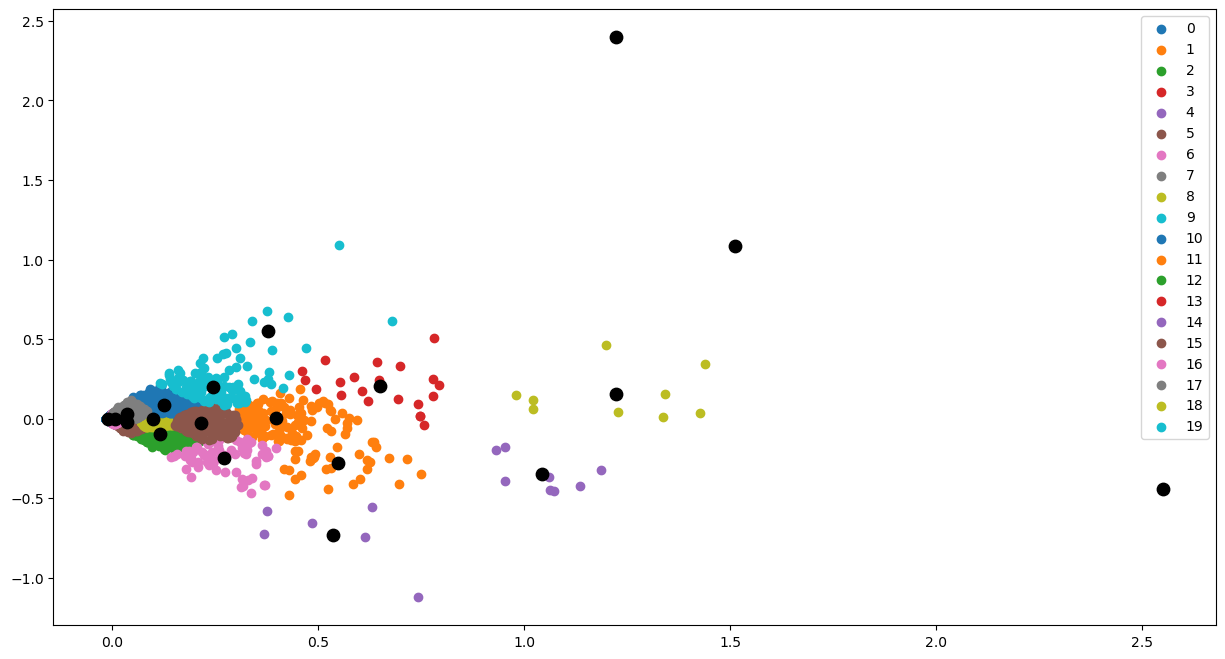

In [33]:
centroids = model_Tfid.cluster_centers_
unique_labels = np.unique(y_pred_Tfid)
 
# Plot 2D result
fig = plt.figure(1, figsize=(15, 8))
for i in unique_labels:
    plt.scatter(X2_TfidV[y_pred_Tfid == i , 0] , X2_TfidV[y_pred_Tfid == i , 1] , label=i)
plt.scatter(centroids[:,0] , centroids[:,1] , s=80, color='k')
plt.legend()
plt.show()

Due to cluster size, I can't really interpret those result.

2. With the short version of data (not including headers, footers and quotes)

a. Vectorize text to allow clustering by Kmeans which requiere numerical values
First TfidVectorizer

In [124]:

TfidV_train_short = TfidV.fit_transform(X_train_short)
TfidV_test_short = TfidV.fit_transform(X_test_short)
print(TfidV_train_short.shape)
print(TfidV_test_short.shape)


(11314, 39115)
(7532, 27818)


Second vectorization method = CountVectorizer

In [81]:
CountV_train_short = CountV.fit_transform(X_train_short)
CountV_test_short = CountV.fit_transform(X_test_short)
print(CountV_train_short.shape)
print(CountV_test_short.shape)

(11314, 39115)
(7532, 27818)


b. Training Kmeans clustering models

In [82]:
model_Tfid_short = KMeans(k, max_iter=100)

model_Tfid_short.fit(TfidV_train_short)

/Users/fabien/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(max_iter=100, n_clusters=20)

In [83]:
model_CountV_short = KMeans(k,max_iter=100)
model_CountV_short.fit(CountV_train_short)

KMeans(max_iter=100, n_clusters=20)

c. Testing Kmean Clustering models with both vectorization methods, long and short texts

In [91]:
cluster_ids_CountV_short, cluster_sizes_CountV_short = np.unique(model_CountV_short.labels_, return_counts=True)

cluster_ids_Tfid_short, cluster_sizes_Tfid_short = np.unique(model_Tfid_short.labels_, return_counts=True)



Cluster_size = pd.DataFrame({"True_category_size" : sorted(category_sizes_train), 
                             "model_Tfid_Cluster size" : sorted(cluster_sizes_Tfid), 
                             "model_CountV_Cluster size" : sorted(cluster_sizes_CountV),
                             "model_Tfid_short_Cluster size" : sorted(cluster_sizes_Tfid_short), 
                             "model_CountV_short_Cluster size" : sorted(cluster_sizes_CountV_short)})

Cluster_size.loc['Total'] = Cluster_size.sum()
Cluster_size

,True_category_size,model_Tfid_Cluster size,model_CountV_Cluster size,model_Tfid_short_Cluster size,model_CountV_short_Cluster size
0,377,62,1,1,1
1,465,78,1,1,1
2,480,114,1,1,1
3,546,124,1,1,1
4,564,130,1,1,1
5,578,131,1,1,1
6,584,135,1,1,1
7,585,141,1,1,1
8,590,234,1,1,1
9,591,249,1,1,1


Result analysis : Cluster size means no sense with both vectorization method. Especially with "Count_V" method which has 13 clusters with only 1 article, and cluster 19 containing almost all articles.

Metrics comparison for models trained by both vectorization methods :

In [65]:
Kmeans_score_Tfid_short = clust_metrics_alt(model_Tfid_short, TfidV_test_short, y_test_short)
Kmeans_score_CountV_short = clust_metrics_alt(model_CountV_short, CountV_test_short, y_test_short)

Kmeans_score_short = Kmeans_score_Tfid_short.rename(columns = {'Clustering Metrics':'Tfid Vectorizer'})


pdToList_short = list(Kmeans_score_CountV_short['Clustering Metrics'])


Kmeans_score_short['CounterVect'] = pdToList_short

Kmeans_score_short

/Users/fabien/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/fabien/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Tfid Vectorizer,CounterVect
Rand_Index,0.88,0.04
Adjusted_Rand_Index,0.00,0.00
Mutual_Information,2.56,0.12
Normalized_Mutual_Information,0.45,0.03
Adjusted_Mutual_Information,-0.00,0.00
Homogeneity_score,0.29,0.01
Completeness_score,1.00,1.00
V_measure_score,0.45,0.03
Fowlkes_Mallows_score,0.00,0.00
Silhouette_score,-0.00,0.78


Evaluation metrics still very poor. But we can observe a slight increase for some score with the Tfid Vectorization method.
Note that 2 metrics 'Calinski_Harabasz_score' and 'Davies_Bouldin_score' return error on calculation and were remove for the evaluation function.

Next, we are going to explore the top 10 words of each clusters.

In [122]:
top_10_Tfid_short = cluster_top_words(model_Tfid_short, TfidV, k, 10)
top_10_Tfid_short

,Cluster 1:,Cluster 2:,Cluster 3:,Cluster 4:,Cluster 5:,Cluster 6:,Cluster 7:,Cluster 8:,Cluster 9:,Cluster 10:,Cluster 11:,Cluster 12:,Cluster 13:,Cluster 14:,Cluster 15:,Cluster 16:,Cluster 17:,Cluster 18:,Cluster 19:,Cluster 20:
0,ragged,rosicrucian,franklinkl,npo,identities,pj,bunny,eller,kbl,translucent,unqualified,faulty,smething,12377,implamentation,keren,intake,recogniton,etudiants,connectivity
1,southpaw,repost,orphans,kimble,daven,skippy,flack,christopher,lyons,transmit,9761,96c,transmit,majd,din,arsenal,mezalim,bnc,earl,availble
2,rages,khayash,kozmic,poland,negatives,collective,deion,episcopalians,f22,aftermarket,palo,sy,declare,historically,bureaucracys,chicago,directories,circumventing,unlimited,bbs
3,tampere_stars,mrminitialize,palmaritas,npri,ishtar,tires,dekorte,bailey,drinkers,kbos,effected,bram,bombay,privacy,cairo,sharon,npri6,idcbbs,93apr26141950,kjell
4,stdio,dws015,events,nizamnamesi,snug,ibaa,deja,eurocrypt,cb650sc,reflects,royalty,avdms8,individualism,dealy,implied,procession,covers,conduit,busmastering,bqz
5,120417,malaria,implamentation,nj,individualism,snug,deity,fairly,everybody,longbow,extropy,provocation,dashed,lekoff,divinely,reporting,tonelli,entertainment,ssk,lyons
6,achieved,room,evening,dallas,feels,breastplate,deities,outlawing,gaze,outlawing,evenchick,arguable,sweeping,socketed,ferreira,m82,answer,totalitarianism,rajneesh,confident
7,monetary,insulated,lancet,painting,fdl,spaghetti,deitch,csce,sustainable,cybernetics,ether,liv,elizabeth,satire,receiver,drawers,scoggin,blankenship,elif,niggers
8,adverse,pushbutton,ebright,romans,sophistication,99,deist,premature,everyones,underdogs,bigwpi,pablo,db74,negligent,ababa,koine,occasions,merican,reinnoculate,ire
9,barred,prozac,rekindled,hts,dashed,hell,deir,finale,oval,sweeping,iskandar,s7g,kahn,dining,memmaker,demonized,clues,9527,murray,deserved


In [123]:
top_10_Tfid_short = cluster_top_words(model_CountV_short, CountV, k, 10)
top_10_Tfid_short

,Cluster 1:,Cluster 2:,Cluster 3:,Cluster 4:,Cluster 5:,Cluster 6:,Cluster 7:,Cluster 8:,Cluster 9:,Cluster 10:,Cluster 11:,Cluster 12:,Cluster 13:,Cluster 14:,Cluster 15:,Cluster 16:,Cluster 17:,Cluster 18:,Cluster 19:,Cluster 20:
0,negatives,aplenty,aplenty,aplenty,aplenty,aplenty,aplenty,aplenty,aplenty,aplenty,conflicts,gelcaps,commonality,aplenty,1267,morally,timorese,elizabeth,hyperthyroidism,lozan
1,ishtar,klikspaanweg,klikspaanweg,applicon,klikspaanweg,klikspaanweg,klikspaanweg,klikspaanweg,klikspaanweg,klikspaanweg,losses,interconnections,bk6,klikspaanweg,088,elizabeth,roommate,deserved,grungy,scanned
2,daven,524737,notwithstanding,execpt,524737,845,12mb,notwithstanding,845,execpt,augustine,maurer,thug,applicon,13902,misleading,rebuke,sweeping,fairly,optimistic
3,identities,rev,24910,845,notwithstanding,486dx33,1r8p64,16th,applicon,applicon,represents,deserved,synoptic,845,1122,origins,provoked,antiauthoritarian,elizabeth,individualism
4,individualism,2151,1808,16th,applicon,applicon,applicon,applicon,notwithstanding,845,collects,siyasiye,sib,12mb,120417,discus,mentality,pallets,careers,feathers
5,snug,execpt,auras,klikspaanweg,1rh9b0inn2r4,12mb,040,tribune,1808,16th,birnbaum,master,c5wewd,07,1329,outlawing,master,hardcopy,gruss,daven
6,sophistication,452,57,12mb,59,16th,524737,24910,pathologist,524737,a06,reb,jackie,1808,1853,scraping,lebrun,carmel,equal,snug
7,sweeping,familynet,familynet,07,27625,1r8p64,auras,execpt,auras,auras,ayl,expansion,gornish,execpt,103242,brutally,hojo,eurocrypt,pbo2,quite
8,dashed,patented,1v,notwithstanding,1808,notwithstanding,augustine,07,passngering,notwithstanding,creator,deans,thorium,notwithstanding,14850,beranek,fac,admirably,teemu,criticize
9,feels,16th,pathologist,2151,familynet,2151,_m,biomed,axiomatic,1r8p64,commonality,damabus,1449,familynet,1449,ernst,mandock,condensers,eller,fabricated


Due to cluster size, I can't really interpret those result.

Projection of cluster.

In [52]:
# PCA Transformation - Reduce dimension to a 2D features shape.

X2_TfidV_short = pca.fit_transform(df_TfidV_train_short)


y_pred_Tfid_short = model_Tfid_short.fit_predict(X2_TfidV_short)

/Users/fabien/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


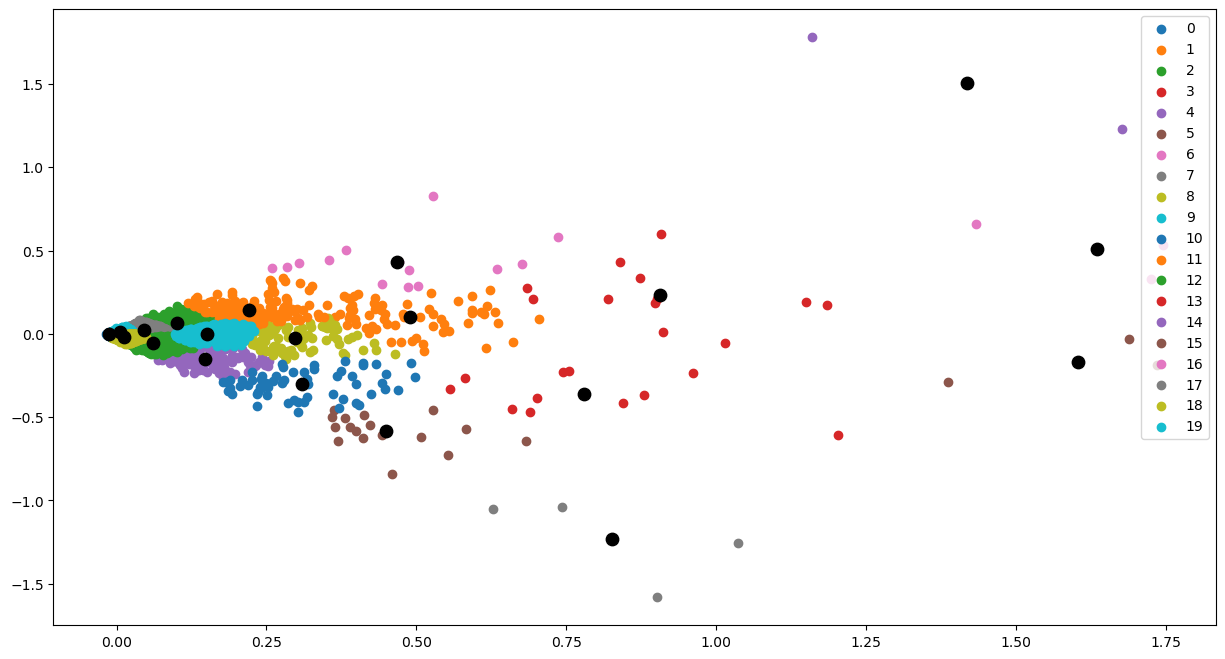

In [53]:
centroids_short = model_Tfid_short.cluster_centers_
unique_labels_short = np.unique(y_pred_Tfid_short)
 
# Plot 2D result
fig = plt.figure(1, figsize=(15, 8))
for i in unique_labels:
    plt.scatter(X2_TfidV_short[y_pred_Tfid_short == i , 0] , X2_TfidV_short[y_pred_Tfid_short == i , 1] , label=i)
plt.scatter(centroids_short[:,0] , centroids_short[:,1] , s=80, color='k')
plt.legend()
plt.show()

3) Test other clustering method, specified to text clustering : "LDA"

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

model_LDA = LatentDirichletAllocation(n_components=20)

model_LDA.fit(TfidV_train)



LatentDirichletAllocation(n_components=20)

In [ ]:
order_centroids = model_LDA.cluster_centers_.argsort()[:, ::-1]
terms = TfidV.get_feature_names_out()
for i in range (k):
    print("Cluster %d:" %(i+1))
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

AttributeError: 'LatentDirichletAllocation' object has no attribute 'cluster_centers_'

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

X_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))


y_pred = model_LDA.predict(TfidV_test)

y_true = TfidV_test.target
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy}")

report = classification_report(y_true, y_pred, target_names= z)
print(report)

AttributeError: 'LatentDirichletAllocation' object has no attribute 'predict'